I'm glad to share my plan. This is based on the landmark notebook by Chris [Here](https://www.kaggle.com/code/cdeotte/xgboost-baseline-0-676). Thanks to him and all the participants who share their ideas.
My inference part is [Here](https://www.kaggle.com/code/takanashihumbert/magic-bingo-inference-part-lb-0-687)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
import polars as pl
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm
from collections import defaultdict
import warnings
from itertools import combinations

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

In [2]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [3]:
%%time
columns = [
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) # time used for each action
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) # location x changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) # location y changed for click 
         .abs()
         .over(["session_id", "level_group"])
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

df = (pl.read_parquet("/kaggle/input/game-play-train-parquet/train.parquet")
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
df3 = df.filter(pl.col("level_group")=='13-22')

CPU times: user 11.9 s, sys: 8.51 s, total: 20.4 s
Wall time: 13.9 s


In [4]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

Here are some useful features:
* event numbers for each sessions
* average, minimum and maximum time consumed for each 'event_name' and 'name'
* features about 'bingo'(when users successfully click the correct place and finish the phased games), which can be translated as comprehension and deductive ability.

In [5]:
print('df1 elapsed_time 결측값 : ', pd.isnull(df1['elapsed_time']).sum())
print('df1 index 결측값 : ', pd.isnull(df1['index']).sum())
print('df2 elapsed_time 결측값 : ', pd.isnull(df2['elapsed_time']).sum())
print('df2 index 결측값 : ', pd.isnull(df2['index']).sum())
print('df3 elapsed_time 결측값 : ', pd.isnull(df3['elapsed_time']).sum())
print('df3 index 결측값 : ', pd.isnull(df3['index']).sum())

df1 elapsed_time 결측값 :  0
df1 index 결측값 :  0
df2 elapsed_time 결측값 :  0
df2 index 결측값 :  0
df3 elapsed_time 결측값 :  0
df3 index 결측값 :  0


In [6]:
def feature_engineer(x, grp, use_extra, feature_suffix):
    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),

        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],

        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS],

        *[pl.col("fqid").filter(pl.col("fqid") == c).count().alias(f"{c}_fqid_counts{feature_suffix}")
          for c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in fqid_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in fqid_lists],


        *[pl.col("text_fqid").filter(pl.col("text_fqid") == c).count().alias(f"{c}_text_fqid_counts{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in text_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in text_lists],

        *[pl.col("room_fqid").filter(pl.col("room_fqid") == c).count().alias(f"{c}_room_fqid_counts{feature_suffix}")
          for c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in room_lists],
        *[pl.col("elapsed_time_diff").filter(pl.col("room_fqid") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in room_lists],

        *[pl.col("event_name").filter(pl.col("event_name") == c).count().alias(f"{c}_event_name_counts{feature_suffix}")
          for c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).std().alias(f"{c}_ET_std_{feature_suffix}")for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for
          c in event_name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for
          c in event_name_feature],

        *[pl.col("name").filter(pl.col("name") == c).count().alias(f"{c}_name_counts{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          name_feature],
        *[pl.col("elapsed_time_diff").filter(pl.col("name") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          name_feature],

        *[pl.col("level").filter(pl.col("level") == c).count().alias(f"{c}_LEVEL_count{feature_suffix}") for c in LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          LEVELS],
        *[pl.col("elapsed_time_diff").filter(pl.col("level") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          LEVELS],

        *[pl.col("level_group").filter(pl.col("level_group") == c).count().alias(f"{c}_LEVEL_group_count{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).std().alias(f"{c}_ET_std_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).mean().alias(f"{c}_ET_mean_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).max().alias(f"{c}_ET_max_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).min().alias(f"{c}_ET_min_{feature_suffix}") for c in
          level_groups],
        *[pl.col("elapsed_time_diff").filter(pl.col("level_group") == c).sum().alias(f"{c}_ET_sum_{feature_suffix}") for c in
          level_groups],

        *[pl.col("index").filter((pl.col("level") == c) & (pl.col('room_fqid') == d)).count().alias(f"{c}{d}_level_room_count{feature_suffix}") for c in LEVELS for d in room_lists],


    ]

    df = x.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")
    
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='logbook'))|(pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='logbook'))|(pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
                
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='businesscards'))|(pl.col("fqid")=="businesscards.card_bingo.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("bisinesscards_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='businesscards'))|(pl.col("fqid")=="businesscards.card_bingo.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("bisinesscards_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")|(pl.col("fqid")=="journals_flag.pic_1.bingo")|(pl.col("fqid")=="journals_flag.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")|(pl.col("fqid")=="journals_flag.pic_1.bingo")|(pl.col("fqid")=="journals_flag.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')
        
    return df.to_pandas()

In [7]:
%%time
df1 = feature_engineer(df1, grp='0-4', use_extra=True, feature_suffix='')
print('df1 done')
df2 = feature_engineer(df2, grp='5-12', use_extra=True, feature_suffix='')
print('df2 done')
df3 = feature_engineer(df3, grp='13-22', use_extra=True, feature_suffix='')
print('df3 done')

df1 done
df2 done
df3 done
CPU times: user 2min 8s, sys: 5.58 s, total: 2min 14s
Wall time: 1min 13s


Unwrapped panic from Python code 에러발생 - TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'', src/apply/series.rs:219:19  
아무래도 filter에서 데이터를 더 추가하니 NaN 값이 있어 max-min 할 때, 발생하는 오류입니다.   
대처법으로는...

1. NaN 값들 다 0으로 변환
2. 데이터들을 살펴보며 NaN이 있는 데이터 추가를 하지 않기

- bisinesscards에서 에러가 발생했습니다.
- bisinesscards에서 apply 부분에 if s.len()>0 else 0을 추가하여 에러를 바로잡았습니다.


In [8]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)


    return train

In [9]:
%%time
df1 = time_feature(df1)
print('df1 done')
df2 = time_feature(df2)
print('df2 done')
df3 = time_feature(df3)
print('df3 done')

df1 done
df2 done
df3 done
CPU times: user 157 ms, sys: 79 µs, total: 157 ms
Wall time: 156 ms



Remove some redundant features

In [10]:
df2['navigate_click_ET_min_']

0        0
1        0
2        0
3        0
4        0
        ..
11774    0
11775    0
11776    0
11777    0
11778    0
Name: navigate_click_ET_min_, Length: 11779, dtype: int32

In [11]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in tqdm(df1.columns):
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in tqdm(df2.columns):
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in tqdm(df3.columns):
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

1180 900 785


  0%|          | 0/2350 [00:00<?, ?it/s]

elapsed_time_diff_min_
worker_fqid_counts
archivist_fqid_counts
confrontation_fqid_counts
crane_ranger_fqid_counts
flag_girl_fqid_counts
archivist_glasses_fqid_counts
journals_fqid_counts
seescratches_fqid_counts
groupconvo_flag_fqid_counts
expert_fqid_counts
businesscards_fqid_counts
ch3start_fqid_counts
tofrontdesk_fqid_counts
savedteddy_fqid_counts
glasses_fqid_counts
tunic.drycleaner_fqid_counts
reader_flag_fqid_counts
tunic.library_fqid_counts
tracks_fqid_counts
tunic.capitol_2_fqid_counts
trigger_scarf_fqid_counts
reader_fqid_counts
tunic.capitol_1_fqid_counts
journals.pic_0.next_fqid_counts
unlockdoor_fqid_counts
what_happened_fqid_counts
tunic.humanecology_fqid_counts
colorbook_fqid_counts
logbook_fqid_counts
businesscards.card_0.next_fqid_counts
journals.hub.topics_fqid_counts
logbook.page.bingo_fqid_counts
journals.pic_1.next_fqid_counts
journals_flag_fqid_counts
reader.paper0.next_fqid_counts
tracks.hub.deer_fqid_counts
reader_flag.paper0.next_fqid_counts
trigger_coffee_fqid

  0%|          | 0/2358 [00:00<?, ?it/s]

elapsed_time_diff_min_
wells_fqid_counts
confrontation_fqid_counts
crane_ranger_fqid_counts
groupconvo_fqid_counts
flag_girl_fqid_counts
archivist_glasses_fqid_counts
seescratches_fqid_counts
groupconvo_flag_fqid_counts
cs_fqid_counts
teddy_fqid_counts
expert_fqid_counts
ch3start_fqid_counts
savedteddy_fqid_counts
glasses_fqid_counts
reader_flag_fqid_counts
tracks_fqid_counts
tunic.capitol_2_fqid_counts
unlockdoor_fqid_counts
colorbook_fqid_counts
journals_flag_fqid_counts
tracks.hub.deer_fqid_counts
reader_flag.paper0.next_fqid_counts
journals_flag.pic_0.bingo_fqid_counts
plaque.face.date_fqid_counts
notebook_fqid_counts
tunic.wildlife_fqid_counts
tocage_fqid_counts
tocollectionflag_fqid_counts
chap4_finale_c_fqid_counts
lockeddoor_fqid_counts
journals_flag.hub.topics_fqid_counts
reader_flag.paper2.bingo_fqid_counts
tunic.flaghouse_fqid_counts
directory.closeup.archivist_fqid_counts
intro_fqid_counts
retirement_letter_fqid_counts
remove_cup_fqid_counts
journals_flag.pic_0.next_fqid_co

  0%|          | 0/2356 [00:00<?, ?it/s]

elapsed_time_diff_min_
archivist_fqid_counts
groupconvo_fqid_counts
cs_fqid_counts
trigger_scarf_fqid_counts
what_happened_fqid_counts
logbook.page.bingo_fqid_counts
trigger_coffee_fqid_counts
wellsbadge_fqid_counts
plaque.face.date_fqid_counts
notebook_fqid_counts
businesscards.card_bingo.bingo_fqid_counts
chap2_finale_c_fqid_counts
tunic.capitol_0_fqid_counts
intro_fqid_counts
reader.paper2.bingo_fqid_counts
retirement_letter_fqid_counts
magnify_fqid_counts
togrampa_fqid_counts
janitor_fqid_counts
chap1_finale_fqid_counts
report_fqid_counts
chap1_finale_c_fqid_counts
door_block_talk_fqid_counts
block_magnify_fqid_counts
block_fqid_counts
block_0_fqid_counts
door_block_clean_fqid_counts
doorblock_fqid_counts
tocloset_fqid_counts
block_tomap2_fqid_counts
block_tocollection_fqid_counts
block_tomap1_fqid_counts
block_badge_fqid_counts
block_badge_2_fqid_counts
block_1_fqid_counts
tunic.historicalsociety.frontdesk.archivist.newspaper_text_fqid_counts
tunic.historicalsociety.entry.groupcon

In [12]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

In [13]:
FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 539 942 1164 features
We will train with 11779 users info


In [14]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }

    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=0)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        # SAVE MODEL, PREDICT VALID OOF
        oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 539
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_name_counts,0.017874
plaque_fqid_counts,0.013409
chap1_finale_c_ET_sum_,0.011646
checkpoint_ET_sum_,0.010109
tunic.capitol_0.hall_ET_sum_,0.009833
tunic.historicalsociety.entry.groupconvo_ET_mean_,0.007956
tunic.historicalsociety.collection.cs_ET_mean_,0.007545
3tunic.historicalsociety.collection_level_room_count,0.007440
tunic.capitol_0.hall_ET_max_,0.007025


#########################
### question 2 with features 539
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_name_counts,0.008296
object_click_event_name_counts,0.007065
checkpoint_ET_sum_,0.006342
report_ET_min_,0.006028
tunic.capitol_0.hall_ET_sum_,0.005841
checkpoint_ET_max_,0.005183
4_ET_sum_,0.004972
tunic.historicalsociety.collection.gramps.found_ET_min_,0.004834
chap1_finale_c_ET_sum_,0.004791


#########################
### question 3 with features 539
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_name_counts,0.007117
object_click_event_name_counts,0.005991
checkpoint_ET_mean_,0.005474
plaque_fqid_counts,0.005001
tunic.capitol_0.hall_ET_max_,0.004933
checkpoint_ET_min_,0.004768
checkpoint_ET_sum_,0.004680
4_ET_max_,0.004579
tunic.historicalsociety.collection_room_fqid_counts,0.004570


#########################
### question 4 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
tunic.library.frontdesk.worker.wells_ET_mean_,0.019398
tunic.library.frontdesk.worker.wells_ET_sum_,0.013473
tunic.historicalsociety.frontdesk_room_fqid_counts,0.012653
tunic.library.frontdesk.worker.hello_ET_mean_,0.010303
5-12_LEVEL_group_count,0.008809
session_number_,0.008707
basic_name_counts,0.007852
tunic.library.frontdesk.worker.hello_ET_sum_,0.007758
tunic.drycleaner.frontdesk.worker.hub_ET_mean_,0.007694


#########################
### question 5 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
5-12_LEVEL_group_count,0.018551
session_number_,0.017038
basic_name_counts,0.014216
undefined_name_counts,0.012521
11_LEVEL_count,0.006566
tunic.historicalsociety.frontdesk_room_fqid_counts,0.004708
tunic.historicalsociety.stacks_room_fqid_counts,0.004185
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.004032
map_click_event_name_counts,0.003866


#########################
### question 6 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_name_counts,0.016807
5-12_LEVEL_group_count,0.016019
session_number_,0.015271
11_LEVEL_count,0.008366
undefined_name_counts,0.007090
11_ET_sum_,0.005295
journals.pic_0.next_fqid_counts,0.004934
tunic.historicalsociety.frontdesk_room_fqid_counts,0.003790
text_fqid_unique_,0.003780


#########################
### question 7 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.014444
5-12_LEVEL_group_count,0.014276
basic_name_counts,0.010830
undefined_name_counts,0.007797
11_LEVEL_count,0.006639
tunic.historicalsociety.frontdesk_room_fqid_counts,0.004614
9_LEVEL_count,0.003799
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.003140
11tunic.historicalsociety.entry_level_room_count,0.003040


#########################
### question 8 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_name_counts,0.008138
5-12_LEVEL_group_count,0.006278
11_LEVEL_count,0.005812
session_number_,0.005009
text_fqid_unique_,0.004733
undefined_name_counts,0.003979
object_click_event_name_counts,0.003461
map_click_event_name_counts,0.003283
object_click_ET_sum_,0.002711


#########################
### question 9 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.018947
5-12_LEVEL_group_count,0.018693
11_LEVEL_count,0.011400
basic_name_counts,0.010689
undefined_name_counts,0.007553
11tunic.historicalsociety.stacks_level_room_count,0.004710
text_fqid_unique_,0.004328
tunic.historicalsociety.frontdesk_room_fqid_counts,0.003395
tunic.historicalsociety.stacks_room_fqid_counts,0.003391


#########################
### question 10 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
11_LEVEL_count,0.014291
basic_name_counts,0.012347
5-12_LEVEL_group_count,0.012277
session_number_,0.011524
tunic.historicalsociety.stacks_room_fqid_counts,0.007463
object_click_event_name_counts,0.004568
undefined_name_counts,0.004479
11tunic.historicalsociety.stacks_level_room_count,0.003139
tunic.humanecology.frontdesk.worker.intro_ET_mean_,0.003015


#########################
### question 11 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
5-12_LEVEL_group_count,0.012806
session_number_,0.012745
basic_name_counts,0.010127
11_LEVEL_count,0.009557
object_click_event_name_counts,0.005801
undefined_name_counts,0.004580
tunic.historicalsociety.stacks_room_fqid_counts,0.003858
reader_fqid_counts,0.003084
observation_click_ET_max_,0.002853


#########################
### question 12 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.007035
5-12_LEVEL_group_count,0.006837
tunic.historicalsociety.frontdesk_room_fqid_counts,0.004700
basic_name_counts,0.004525
navigate_click_event_name_counts,0.004195
undefined_name_counts,0.003930
reader_fqid_counts,0.003825
map_click_event_name_counts,0.003694
12tunic.historicalsociety.frontdesk_level_room_count,0.003420


#########################
### question 13 with features 942
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
object_click_event_name_counts,0.016280
journals_bingo_duration,0.011275
object_click_ET_sum_,0.011147
11tunic.historicalsociety.stacks_level_room_count,0.006968
room_fqid_unique_,0.006071
11_LEVEL_count,0.005424
journals_bingo_indexCount,0.004561
tunic.historicalsociety.stacks_room_fqid_counts,0.004412
tunic.historicalsociety.collection_ET_min_,0.003983


#########################
### question 14 with features 1164
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.016436
13-22_LEVEL_group_count,0.013593
undefined_name_counts,0.013156
map_click_event_name_counts,0.007950
flag_girl_fqid_counts,0.005941
text_fqid_unique_,0.005836
navigate_click_event_name_counts,0.005679
room_fqid_unique_,0.005129
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.004932


#########################
### question 15 with features 1164
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
session_number_,0.013410
tocloset_dirty_fqid_counts,0.012446
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts,0.010329
map_click_event_name_counts,0.009990
13-22_LEVEL_group_count,0.009843
flag_girl_fqid_counts,0.007813
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_std_,0.007448
tocloset_dirty_ET_std_,0.006438
basic_name_counts,0.005996


#########################
### question 16 with features 1164
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
basic_name_counts,0.002257
tunic.library.frontdesk.worker.flag_ET_sum_,0.002148
15tunic.historicalsociety.closet_dirty_level_room_count,0.002068
tunic.library.frontdesk.worker.nelson_ET_sum_,0.001945
navigate_click_event_name_counts,0.001929
tunic.library.frontdesk.worker.nelson_ET_max_,0.001893
screen_coor_y_sum_,0.001834
tunic.library.frontdesk.worker.nelson_ET_mean_,0.001820
tunic.kohlcenter.halloffame_ET_min_,0.001811


#########################
### question 17 with features 1164
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
13-22_ET_sum_,0.007216
elapsed_time_diff_sum_,0.006025
tunic.flaghouse.entry_ET_sum_,0.004760
basic_ET_sum_,0.004618
tunic.library.frontdesk_ET_sum_,0.004225
21_ET_sum_,0.003324
20_ET_sum_,0.002932
tunic.wildlife.center_ET_sum_,0.002906
navigate_click_ET_sum_,0.002568


#########################
### question 18 with features 1164
#########################
1 , 2 , 3 , 4 , 5 , 


,mean
feature,
13-22_LEVEL_group_count,0.004740
screen_coor_x_sum_,0.004365
session_number_,0.004107
undefined_name_counts,0.003756
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_ET_sum_,0.003744
tocloset_dirty_fqid_counts,0.003591
map_click_event_name_counts,0.003462
flag_girl_fqid_counts,0.003399
close_ET_sum_,0.003190


CPU times: user 7min 40s, sys: 10.2 s, total: 7min 50s
Wall time: 7min 22s


In [15]:
(oof_xgb.values.reshape(-1)>0.4).astype('int')

array([1, 1, 1, ..., 1, 1, 1])

0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

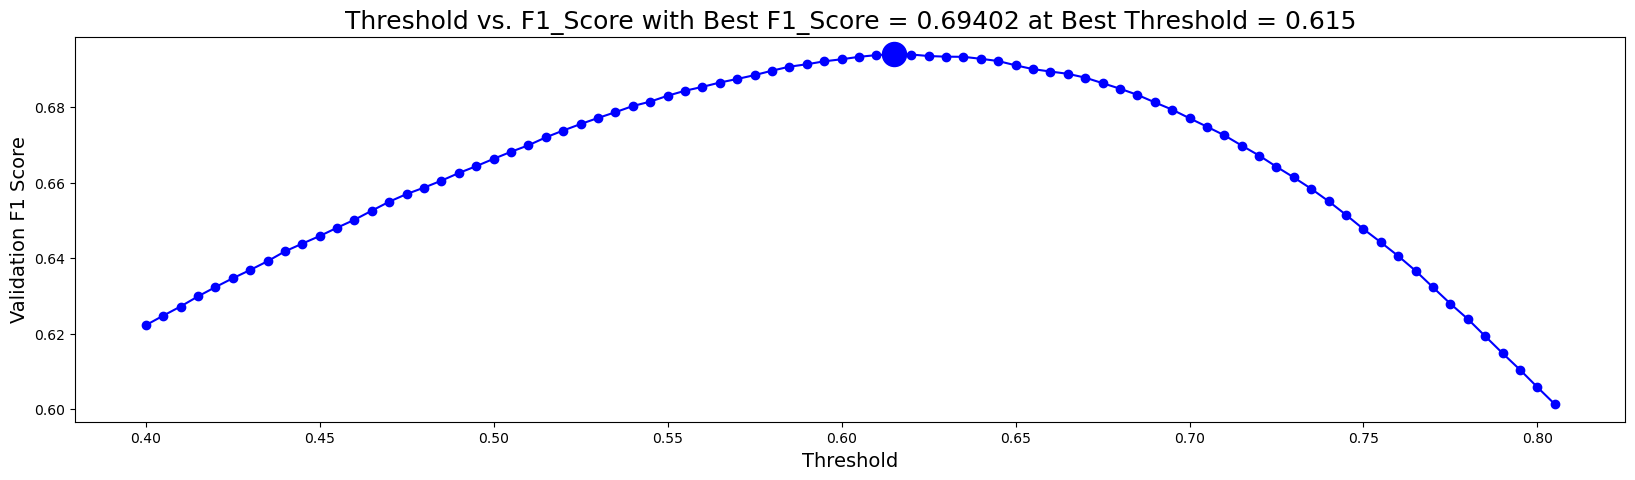

In [16]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    # f1_socre 'macro' 공부
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

Now we use full data to retrain our models with the best iterations, and save them. 

In [17]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'lots_feature_XGB_question{t}.xgb')
    
    print()

#########################
### question 1 features 539

#########################
### question 2 features 539

#########################
### question 3 features 539

#########################
### question 4 features 942

#########################
### question 5 features 942

#########################
### question 6 features 942

#########################
### question 7 features 942

#########################
### question 8 features 942

#########################
### question 9 features 942

#########################
### question 10 features 942

#########################
### question 11 features 942

#########################
### question 12 features 942

#########################
### question 13 features 942

#########################
### question 14 features 1164

#########################
### question 15 features 1164

#########################
### question 16 features 1164

#########################
### question 17 features 1164

#########################
### question 18 features 11

We save features names as dict for each questions

In [18]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3

f_save = open('importance_dict.pkl', 'wb')
# pickle 공부
pickle.dump(importance_dict, f_save)
f_save.close()